# Implementation of Space Invader with Reinforcement Learning

### Dayyan Ahmad 21L-5669
### Muhammad Ibrahim 21L-5656 
### Minahil 21L-5660

## Testing Libraries


In [4]:
import gym
import random

In [3]:
env = gym.make('SpaceInvaders-v4',render_mode = 'human',full_action_space =False, repeat_action_probability =0.1,obs_type = 'rgb')
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [5]:
actions 

6

In [7]:
import time
import matplotlib.pyplot as plt

In [8]:
env.reset

<bound method OrderEnforcing.reset of <OrderEnforcing<PassiveEnvChecker<AtariEnv<SpaceInvaders-v4>>>>>

In [10]:
num_actions = env.action_space.n

In [14]:
print(num_actions)

6


In [16]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [18]:
actionDict ={'q':0, 's':1, 'd':2,'a':3,'j':4,'k':5}

In [20]:
env.reset()
obs, reward,terminated,truncated,info = env.step(2)


D:\Dayyan\Jupyter\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


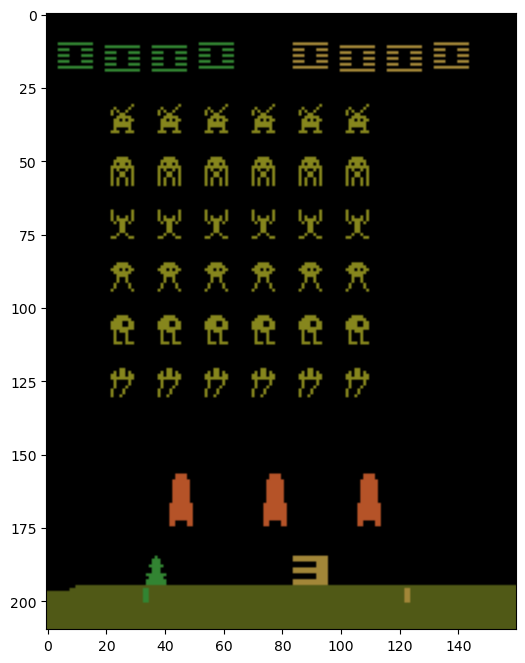

In [22]:
plt.figure(figsize=(8,8))
plt.imshow(obs)

In [24]:
print(reward)

0.0


In [29]:
import keyboard

In [ ]:
totalReward = 0
while True:
    event = keyboard.read_event()
    if actionDict.get(event.name,-1) != 1:
        obs, reward,terminated,truncated,info = env.step(actionDict.get(event.name,-1))
        totalReward=totalReward+reward
        env.render()
        time.sleep(0.05)

In [ ]:
env.reset()
env.close()

In [26]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

%matplotlib inline

The size of frame is:  (210, 160, 3)
No. of Actions:  6


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

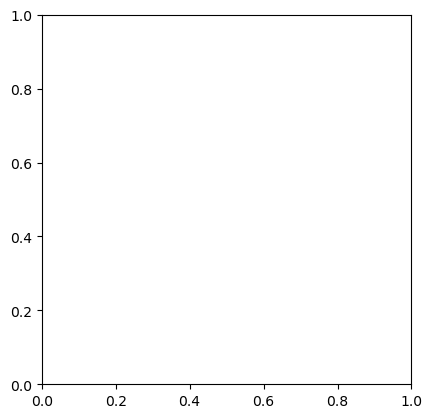

In [28]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

## Random Model

In [30]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, finished,info = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

D:\Dayyan\Jupyter\Lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Your Score at end of game is:  85.0


# Agent train


In [6]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
import numpy as np
import tensorflow as tf
import ale_py as ALE

In [20]:
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 200  # Limit training episodes, will run until solved if smaller than 1

env = gym.make("ALE/SpaceInvaders-v5", render_mode="human")
env = AtariPreprocessing(env, frame_skip=1)
env = FrameStack(env, 4)
env.seed(seed)

(3444837047, 2669555309)

In [22]:
num_actions = 6


def create_q_model():
    # Network defined by the Deepmind paper
    return keras.Sequential(
        [
            layers.Lambda(
                lambda tensor: keras.ops.transpose(tensor, [0, 2, 3, 1]),
                output_shape=(84, 84, 4),
                input_shape=(4, 84, 84),
            ),
            # Convolutions on the frames on the screen
            layers.Conv2D(32, 8, strides=4, activation="relu", input_shape=(4, 84, 84)),
            layers.Conv2D(64, 4, strides=2, activation="relu"),
            layers.Conv2D(64, 3, strides=1, activation="relu"),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(num_actions, activation="linear"),
        ]
    )


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()


In [ ]:
max_episodes = 200
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)


action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

epsilon_random_frames = 50000
epsilon_greedy_frames = 1000000.0
max_memory_length = 100000
update_after_actions = 4
update_target_network = 10000
loss_function = keras.losses.Huber()

while True:
    observation, _ = env.reset()
    state = np.array(observation)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            action = np.random.choice(num_actions)
        else:
            state_tensor = keras.ops.convert_to_tensor(state)
            state_tensor = keras.ops.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)

            action = keras.ops.argmax(action_probs[0]).numpy()

        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        state_next, reward, done, _, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = keras.ops.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            updated_q_values = rewards_sample + gamma * keras.ops.amax(
                future_rewards, axis=1
            )
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = keras.ops.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            model_target.set_weights(model.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    print("Episode: ",episode_count, " has reward ", episode_reward)
    episode_count += 1
    
    if running_reward > 2000:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if (
        max_episodes > 0 and episode_count >= max_episodes
    ):  # Maximum number of episodes reached
        print("Stopped at episode {}!".format(episode_count))
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [77]:
print(episode_reward_history)

[40.0, 60.0, 75.0, 75.0, 80.0, 90.0, 105.0, 105.0, 105.0, 125.0, 125.0, 130.0, 135.0, 135.0, 135.0, 135.0, 135.0, 155.0, 165.0, 165.0, 170.0, 180.0, 185.0, 210.0, 210.0, 215.0, 240.0, 320.0, 320.0, 610.0]


In [79]:
max(episode_reward_history)

610.0